In [2]:
from nilearn import datasets 
#fetching msdl atlas 
msdl_atlas = datasets.fetch_atlas_msdl()
#loading atlas image stored in 'maps'
atlas_filename = msdl_atlas['maps']
#loading atlas data stored in 'labels'
labels = msdl_atlas['labels']


from nilearn.input_data import NiftiMapsMasker
#introducing mask which forms time series from fmri data 
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize = True, verbose =5)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
C:\Users\katia\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
C:\Users\katia\anaconda3\lib\site-packages\numpy\lib\npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Se

78_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMapsMasker.fit_transform] loading regions from C:\Users\katia\nilearn_data\msdl_atlas\MSDL_rois\msdl_rois.nii
[NiftiMapsMasker.transform_single_imgs] Loading data from C:\Users\katia\nilearn_data\development_fmri\development_fmri\sub-pixar079_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMapsMasker.fit_transform] loading regions from C:\Users\katia\nilearn_data\msdl_atlas\MSDL_rois\msdl_rois.nii
[NiftiMapsMasker.transform_single_imgs] Loading data from C:\Users\katia\nilearn_data\development_fmri\development_fmri\sub-pixar080_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extract

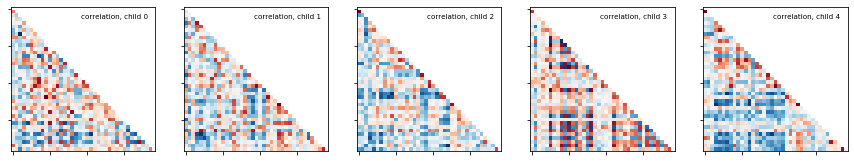

In [3]:
#download full dataset 
full_dataset = datasets.fetch_development_fmri(n_subjects = 122, age_group = 'child')
#create empty array for the children's time series
children = []
for func_file, confound_file in zip(
    full_dataset.func,
    full_dataset.confounds):
    time_series = masker.fit_transform(func_file, confounds = confound_file)
    children.append(time_series)
print('The dataset has {0} children.'.format(len(children)))

children1= children
children2 = children
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(children2)
print('Correlations of children are stacked in an array of shape {0}'.format(correlation_matrices.shape))

#plot lower triangle of first five children in correlation_matrices array
from nilearn import plotting
from matplotlib import pyplot as plt
_, axes=plt.subplots(1, 5, figsize=(15,5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax, title='correlation, child {}'.format(i))

In [4]:
import numpy as np
vectorized_connectivity = np.empty((122, 1521))

correlation_matrices_lower=np.tril(correlation_matrices)
correlation_matrices_lower.shape



(122, 39, 39)

In [5]:
print(correlation_matrices_lower[0])

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.49460792  1.          0.         ...  0.          0.
   0.        ]
 [ 0.10675522  0.01878237  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.1079895   0.05584929  0.02723431 ...  1.          0.
   0.        ]
 [ 0.53490243  0.2440929   0.02234927 ...  0.10548368  1.
   0.        ]
 [ 0.19234932  0.3266371  -0.1595786  ...  0.11670408  0.49004737
   1.        ]]


In [6]:
for i, (matrix) in enumerate(zip(correlation_matrices_lower)):
    vectorized_connectivity[i] =np.ravel(correlation_matrices_lower[i])


  



(122, 1521)
(122, 1)
              0             1  ...             4             5
0 -2.091588e-17 -4.121759e-16  ... -1.212471e-16  6.917473e-18
1  1.643449e-18 -7.711562e-18  ... -1.436992e-17 -8.204594e-17
2 -1.194080e-18  3.233786e-17  ...  1.785039e-16  2.154592e-16
3 -8.700790e-19  4.653808e-17  ... -1.850338e-17  1.836510e-17
4  9.792630e-19 -7.037320e-18  ... -5.890434e-17 -4.745242e-17

[5 rows x 6 columns]
[10.25 18.02 24.07 28.72 32.79 36.33 39.6  42.47 45.16 47.71 49.96 52.01]
3.2693811965634056
[0.10252027 0.07765835 0.06047729 0.0465158  0.04068527 0.03537001
 0.03273026 0.02870684 0.02693504 0.02548093 0.02248056 0.02054245]
[83.14472108 72.36421793 63.85956815 56.0054168  52.37794128 48.83681863
 46.97908487 43.99694251 42.61756682 41.4512327  38.93438914 37.21824866]


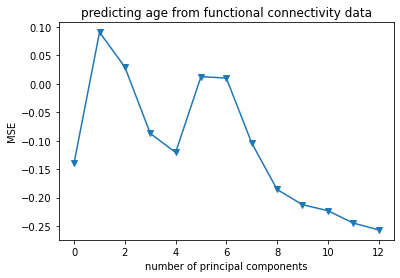

In [11]:
#remove age from phenotypic data 
pheno = full_dataset.phenotypic
age = np.empty((122,1))
for i in range(122):
    age[i] = pheno[i][1]
    
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



rng = np.random.RandomState(0)
#pcr 
X = vectorized_connectivity
y = age 
print(X.shape)
print(y.shape)

#splitting into train and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

#preprocessing
Xstd = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=12)
X_reduced_train = pca.fit_transform(Xstd)

print(pd.DataFrame(pca.components_.T).loc[:4,:5])

#cross validation, 10 folds
n = len(X_reduced_train)
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
regr = LinearRegression()
mse = []

score = cross_val_score(regr, np.ones((n,1)), y_train, cv=cv).mean()
mse.append(score) 

for i in np.arange(1,13):
    score = cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=cv).mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('number of principal components')
plt.ylabel('MSE')
plt.title('predicting age from functional connectivity data MSE vs. number of components')

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))


X_reduced_test = pca.transform(X_test)
regr= LinearRegression()
regr.fit(X_reduced_train, y_train)

pred = regr.predict(X_reduced_test)
print(mean_squared_error(y_test, pred))


print(pca.explained_variance_ratio_)
print(pca.singular_values_)



